<a href="https://colab.research.google.com/github/mmaruthi/Deep_Learning_EVA4_Phase1/blob/master/Session10/Albumentations%2BLRFinder%2BGradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mounting the drive and copying the code from github to drive
from google.colab import drive 
drive.mount('/content/gdrive')
%cd gdrive/My Drive/project_folder
!git clone https://github.com/mmaruthi/Deep_Learning_EVA4_Phase1
%cd Deep_Learning_EVA4_Phase1/Session10
! ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/project_folder
fatal: destination path 'Deep_Learning_EVA4_Phase1' already exists and is not an empty directory.
/content/gdrive/My Drive/project_folder/Deep_Learning_EVA4_Phase1/Session10
data  models


In [0]:
#!pip install torchviz

In [4]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
#from torchviz import make_dot
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from models import Alb_data_transforms,Model,Dataloaders,Train_losses,Testlosses,Gradcam,LRFinder

  pip install torch-lr-finder -v --global-option="amp"


Below section of code is to get the mean and stdev of train data which will be used for normalization while applying transforms. **No need to execute this everytime** we run the file

In [5]:
train = torchvision.datasets.CIFAR10('./data', train=True, download=True)

n = 0
s = np.zeros(3)
sq = np.zeros(3)
i = 0
batchsize = 128
for data, l in tqdm_notebook(train):
  x = np.array(data)/255                             # Image Normalization 
  s += x.sum(axis=(0,1))                             # Summing up x & y values across 3 channels - CIFAR 10 size is 32,32,3. Useful for mean 
  sq += np.sum(np.square(x), axis=(0,1))             # Summing up x^2 and y^2 values across 3 channels. Useful for std dev calculation
  n += x.shape[0]*x.shape[1]                         # Summing up no: of pixels.Each channel has 32x32. Final pixels per channel = # images * 32 *32
  i += 1

batches = int(i/batchsize)
mu = s/n                               # mean = sum of pixel values/ no: of pixel values. Will return 3 element array as CIFAR10 has 3 channels
std = np.sqrt((sq/n - np.square(mu)))  # std dev = sqrt[sigma{x(i) - mean}^2/N]. Will return 3 element array as CIFAR10 has 3 channels
print('No: Of Train Images:', i, '\n'
      'No: Of Batches:', batches, '\n'
      'Channels Mean:',mu, '\n'
      'Channels Stdev:',std, '\n'
      'Channels squared sum mean:', sq/n, '\n'
      'Total Pixles (N):', n)

Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



No: Of Train Images: 50000 
No: Of Batches: 390 
Channels Mean: [0.49139968 0.48215841 0.44653091] 
Channels Stdev: [0.24703223 0.24348513 0.26158784] 
Channels squared sum mean: [0.30249857 0.29176174 0.26781806] 
Total Pixles (N): 51200000


In [6]:
# 0.4.5 is the latest albumentation version
!pip install albumentations==0.4.5

     |████████████████████████████████| 122kB 7.9MB/s 
     |████████████████████████████████| 634kB 14.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=7bcdc1b923aefa94f81046fcf6ac937018b5729498e098796f13411990a092ee
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=f4fc1b7c2deb8a6a44c4acba51d3cd20b3623423f3c4af69b0213163bce7fe66
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [7]:
import albumentations as A

data_loader = Dataloaders.DataLoader(shuffle=True,batch_size=128,seed=1)

channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)
fillmeans = (np.array(channels_mean)*255).astype(np.uint8) # This is to fill additional space coming up while rotating image
              
test_transforms   = Alb_data_transforms.Albumentations_transform([A.Normalize(mean=channels_mean, std=channels_stdev)])
train_transforms  = Alb_data_transforms.Albumentations_transform([A.Rotate((-15.0, 15.0)),
                                                                  A.HorizontalFlip(),
                                                                  A.IAAAdditiveGaussianNoise(),
                                                                  A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                  A.Normalize(mean=channels_mean, std=channels_stdev),
                                                                  A.Cutout(num_holes=1,max_h_size=8,max_w_size=8) 
                                                                  # fillvalue for cutout= default i.e. 0 as after normalizing mean is 0
                                                                  # size as 8 i.e. 25% of 32x32 CIFAR 10 data
                                                                  
                                                                 ])

train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

trainloader = data_loader.load(train_data)
testloader  = data_loader.load(test_data)

Files already downloaded and verified
Files already downloaded and verified


## Below section of code is to display train images from training set



torch.Size([128, 3, 32, 32])
torch.Size([128])


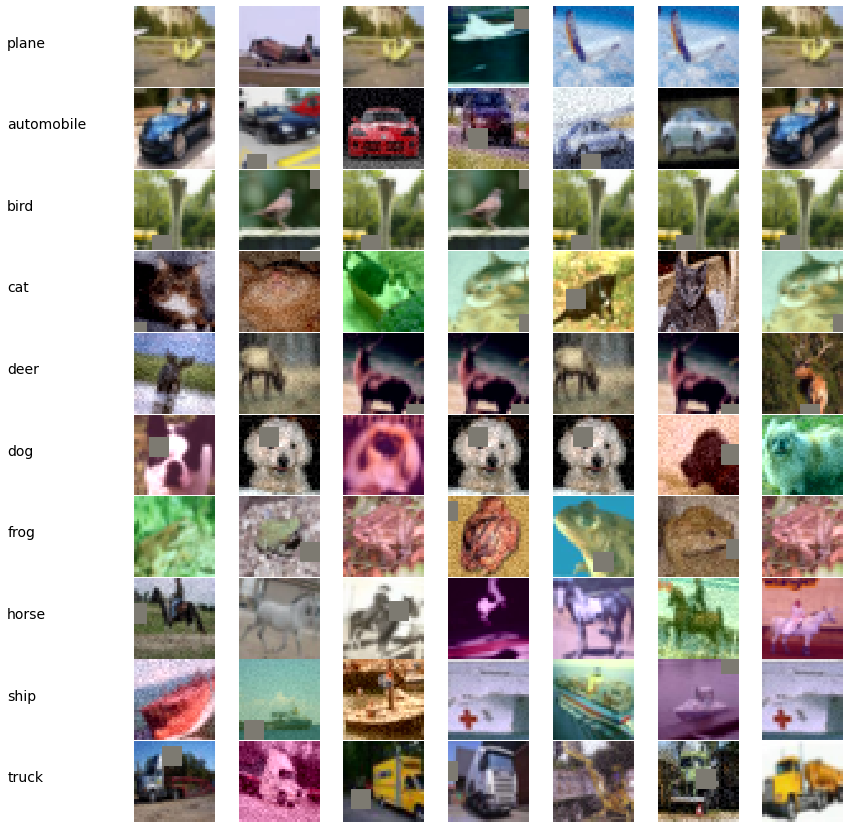

In [8]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt

channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)

# Function to unnormalize and bring back to original pixel values. Transpose is to reshape the image on x & y axes and make it ready for display

def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channels_stdev[i])+channels_mean[i]
  
  return np.transpose(img, (1,2,0))


dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 7 images from each category. 
class_names = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

row, col = 10, 8
num_images = 7
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for class_num in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==class_num)[0], num_images)  ## Selecting 7 random images for each class
    ax = plt.subplot(row, col,class_num*col+1)                             ## Laying out space for display of a particular class
    ax.text(-0.1, 0.5, class_names[class_num], fontsize=14)                ## Displaying class names
    plt.axis('off')
    for j in range(1, num_images+1):                                       ## Displaying images one-by-one for a particular class
      plt.subplot(row, col, class_num*col+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [9]:
!pip install torchsummary
from torchsummary import summary
model = Model.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


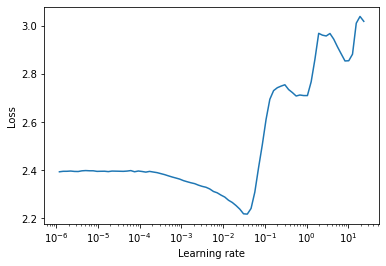

In [10]:
import torch.optim as optim
import torch.nn as nn
from models.LRFinder import LRFinder
L1lambda = 0
L2lambda = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [11]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']

loss

[2.3827035427093506,
 2.3846641421318053,
 2.386189504265785,
 2.3872782643735406,
 2.388582810093462,
 2.3883345515658703,
 2.3918471109443638,
 2.3944053076699423,
 2.393715613270332,
 2.393914776568913,
 2.3927842394998056,
 2.3947897032564742,
 2.3948852968099286,
 2.3958997084983626,
 2.394269202805958,
 2.393975257798564,
 2.3968214511159114,
 2.3978122972765465,
 2.396994441564178,
 2.3969519509122077,
 2.394526242671712,
 2.3949363584174597,
 2.39514115821433,
 2.3935611208533873,
 2.395745476309741,
 2.395400307787528,
 2.395044955712971,
 2.3946581258846282,
 2.395716285283298,
 2.3977465220254506,
 2.3928987948659812,
 2.39602797926819,
 2.394001925153413,
 2.39139808610552,
 2.3944044304460266,
 2.391752285057453,
 2.3892287057433927,
 2.385087321172623,
 2.3809814875045863,
 2.3759196324630056,
 2.371128691962292,
 2.3668668459300037,
 2.3624368608913464,
 2.3561101213967364,
 2.351424336739558,
 2.3471141043233565,
 2.3434796863577074,
 2.3372034457417565,
 2.332159286314

In [12]:
lr

[1.513561248436208e-07,
 1.8620871366628675e-07,
 2.290867652767773e-07,
 2.818382931264454e-07,
 3.467368504525316e-07,
 4.265795188015927e-07,
 5.248074602497726e-07,
 6.456542290346554e-07,
 7.943282347242816e-07,
 9.772372209558107e-07,
 1.2022644346174128e-06,
 1.4791083881682075e-06,
 1.819700858609984e-06,
 2.2387211385683393e-06,
 2.7542287033381663e-06,
 3.388441561392026e-06,
 4.168693834703353e-06,
 5.128613839913649e-06,
 6.309573444801934e-06,
 7.762471166286916e-06,
 9.549925860214359e-06,
 1.1748975549395297e-05,
 1.4454397707459272e-05,
 1.7782794100389226e-05,
 2.187761623949553e-05,
 2.6915348039269167e-05,
 3.3113112148259124e-05,
 4.0738027780411254e-05,
 5.011872336272722e-05,
 6.165950018614821e-05,
 7.585775750291839e-05,
 9.332543007969913e-05,
 0.00011481536214968832,
 0.00014125375446227535,
 0.00017378008287493747,
 0.00021379620895022316,
 0.0002630267991895382,
 0.0003235936569296283,
 0.0003981071705534974,
 0.000489778819368446,
 0.0006025595860743576,
 0

In [0]:
#Take the learning rate where the loss is minimum 
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

In [0]:
train_loss = Train_losses.Train_loss()
test_loss  = Testlosses.Test_loss()

# Train and Test the model 

In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

EPOCH     = 50
#L2_factor = 0.0001
#L1_factor = 0.0005
#OPTIMIZER = optim.SGD(model.parameters(), lr=0.025, momentum=0.9, nesterov=True, weight_decay=L2_factor)
OPTIMIZER  = optimizer
#SCHEDULER = OneCycleLR(OPTIMIZER, max_lr=0.2, steps_per_epoch=len(trainloader), epochs=EPOCH)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, min_lr=1e-7, patience = 2, verbose=True)
train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []

for epoch in range(EPOCH):

    print("EPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,model.device,train_loader=trainloader,optimizer=OPTIMIZER,
                                                         epoch=EPOCH,factor=L1lambda,scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
    test_losses, test_acc   = test_loss.test_loss_calc(model,model.device,test_loader=testloader)

    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Train Loss = 1.372323751449585 Batch Id = 390 Train Accuracy = 41.68 : 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2495, Test Accuracy: 55.78

EPOCH: 1


Train Loss = 0.7182373404502869 Batch Id = 390 Train Accuracy = 61.51 : 100%|██████████| 391/391 [01:04<00:00,  6.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9466, Test Accuracy: 66.63

EPOCH: 2


Train Loss = 0.7114499807357788 Batch Id = 390 Train Accuracy = 70.10 : 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7521, Test Accuracy: 74.69

EPOCH: 3


Train Loss = 0.48548823595046997 Batch Id = 390 Train Accuracy = 74.24 : 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7078, Test Accuracy: 76.65

EPOCH: 4


Train Loss = 0.6954244375228882 Batch Id = 390 Train Accuracy = 77.53 : 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5982, Test Accuracy: 79.28

EPOCH: 5


Train Loss = 0.5981680154800415 Batch Id = 390 Train Accuracy = 79.81 : 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5401, Test Accuracy: 81.58

EPOCH: 6


Train Loss = 0.7115084528923035 Batch Id = 390 Train Accuracy = 81.43 : 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5808, Test Accuracy: 79.92

EPOCH: 7


Train Loss = 0.5610529780387878 Batch Id = 390 Train Accuracy = 82.95 : 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5049, Test Accuracy: 82.91

EPOCH: 8


Train Loss = 0.5418258905410767 Batch Id = 390 Train Accuracy = 84.47 : 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5204, Test Accuracy: 82.87

EPOCH: 9


Train Loss = 0.4425458312034607 Batch Id = 390 Train Accuracy = 85.65 : 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5643, Test Accuracy: 81.87

EPOCH: 10


Train Loss = 0.36356765031814575 Batch Id = 390 Train Accuracy = 86.53 : 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4451, Test Accuracy: 85.17

EPOCH: 11


Train Loss = 0.6234201192855835 Batch Id = 390 Train Accuracy = 87.36 : 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4492, Test Accuracy: 84.78

EPOCH: 12


Train Loss = 0.3038896918296814 Batch Id = 390 Train Accuracy = 88.18 : 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4244, Test Accuracy: 85.87

EPOCH: 13


Train Loss = 0.415677547454834 Batch Id = 390 Train Accuracy = 88.90 : 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4175, Test Accuracy: 86.19

EPOCH: 14


Train Loss = 0.2826511263847351 Batch Id = 390 Train Accuracy = 89.57 : 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4200, Test Accuracy: 86.34

EPOCH: 15


Train Loss = 0.24651522934436798 Batch Id = 390 Train Accuracy = 90.29 : 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3575, Test Accuracy: 88.20

EPOCH: 16


Train Loss = 0.22705323994159698 Batch Id = 390 Train Accuracy = 90.92 : 100%|██████████| 391/391 [01:05<00:00,  6.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4037, Test Accuracy: 87.21

EPOCH: 17


Train Loss = 0.17049266397953033 Batch Id = 390 Train Accuracy = 91.43 : 100%|██████████| 391/391 [01:04<00:00,  6.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4229, Test Accuracy: 86.47

EPOCH: 18


Train Loss = 0.3926011323928833 Batch Id = 390 Train Accuracy = 91.84 : 100%|██████████| 391/391 [01:04<00:00,  6.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4496, Test Accuracy: 86.21

EPOCH: 19


Train Loss = 0.26678234338760376 Batch Id = 390 Train Accuracy = 91.97 : 100%|██████████| 391/391 [01:04<00:00,  6.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4023, Test Accuracy: 87.53

EPOCH: 20


Train Loss = 0.28939568996429443 Batch Id = 390 Train Accuracy = 92.66 : 100%|██████████| 391/391 [01:04<00:00,  6.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3892, Test Accuracy: 88.11

EPOCH: 21


Train Loss = 0.16427412629127502 Batch Id = 390 Train Accuracy = 93.12 : 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4216, Test Accuracy: 86.92

EPOCH: 22


Train Loss = 0.11137843132019043 Batch Id = 390 Train Accuracy = 93.43 : 100%|██████████| 391/391 [01:04<00:00,  6.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3818, Test Accuracy: 88.26

EPOCH: 23


Train Loss = 0.2399124801158905 Batch Id = 390 Train Accuracy = 93.59 : 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3816, Test Accuracy: 88.38

EPOCH: 24


Train Loss = 0.07966624200344086 Batch Id = 390 Train Accuracy = 94.03 : 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3605, Test Accuracy: 88.73

EPOCH: 25


Train Loss = 0.13917651772499084 Batch Id = 390 Train Accuracy = 94.33 : 100%|██████████| 391/391 [01:04<00:00,  6.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3866, Test Accuracy: 88.29

EPOCH: 26


Train Loss = 0.105410635471344 Batch Id = 390 Train Accuracy = 94.58 : 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4154, Test Accuracy: 87.98

EPOCH: 27


Train Loss = 0.2260429412126541 Batch Id = 390 Train Accuracy = 94.69 : 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3791, Test Accuracy: 88.25

EPOCH: 28


Train Loss = 0.19953174889087677 Batch Id = 390 Train Accuracy = 94.97 : 100%|██████████| 391/391 [01:04<00:00,  6.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3789, Test Accuracy: 88.80

EPOCH: 29


Train Loss = 0.1037542000412941 Batch Id = 390 Train Accuracy = 95.31 : 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3832, Test Accuracy: 88.85

EPOCH: 30


Train Loss = 0.0891895666718483 Batch Id = 390 Train Accuracy = 95.39 : 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4544, Test Accuracy: 87.27

EPOCH: 31


Train Loss = 0.20878104865550995 Batch Id = 390 Train Accuracy = 95.67 : 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3971, Test Accuracy: 88.65

EPOCH: 32


Train Loss = 0.1733590066432953 Batch Id = 390 Train Accuracy = 95.90 : 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4213, Test Accuracy: 88.41

EPOCH: 33


Train Loss = 0.14537957310676575 Batch Id = 390 Train Accuracy = 95.68 : 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4213, Test Accuracy: 87.77

EPOCH: 34


Train Loss = 0.12710323929786682 Batch Id = 390 Train Accuracy = 95.91 : 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3872, Test Accuracy: 88.67

EPOCH: 35


Train Loss = 0.19444486498832703 Batch Id = 390 Train Accuracy = 95.94 : 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3984, Test Accuracy: 88.44

EPOCH: 36


Train Loss = 0.12077631801366806 Batch Id = 390 Train Accuracy = 96.20 : 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4042, Test Accuracy: 88.56

EPOCH: 37


Train Loss = 0.08959905803203583 Batch Id = 390 Train Accuracy = 96.28 : 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3852, Test Accuracy: 88.88

EPOCH: 38


Train Loss = 0.08994162827730179 Batch Id = 390 Train Accuracy = 96.47 : 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4056, Test Accuracy: 88.49

EPOCH: 39


Train Loss = 0.1268225908279419 Batch Id = 390 Train Accuracy = 96.44 : 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4049, Test Accuracy: 89.12

EPOCH: 40


Train Loss = 0.052315689623355865 Batch Id = 390 Train Accuracy = 96.54 : 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3749, Test Accuracy: 89.49

EPOCH: 41


Train Loss = 0.14504458010196686 Batch Id = 390 Train Accuracy = 96.56 : 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3901, Test Accuracy: 88.93

EPOCH: 42


Train Loss = 0.06824009865522385 Batch Id = 390 Train Accuracy = 96.71 : 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3896, Test Accuracy: 89.13

EPOCH: 43


Train Loss = 0.0771954357624054 Batch Id = 390 Train Accuracy = 96.72 : 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4199, Test Accuracy: 88.41

EPOCH: 44


Train Loss = 0.09553582966327667 Batch Id = 390 Train Accuracy = 96.82 : 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3988, Test Accuracy: 89.25

EPOCH: 45


Train Loss = 0.18356937170028687 Batch Id = 390 Train Accuracy = 97.06 : 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3984, Test Accuracy: 89.14

EPOCH: 46


Train Loss = 0.06286980211734772 Batch Id = 390 Train Accuracy = 97.00 : 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3873, Test Accuracy: 89.30

EPOCH: 47


Train Loss = 0.026218492537736893 Batch Id = 390 Train Accuracy = 97.11 : 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4064, Test Accuracy: 89.07

EPOCH: 48


Train Loss = 0.05759251117706299 Batch Id = 390 Train Accuracy = 96.91 : 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4055, Test Accuracy: 88.90

EPOCH: 49


Train Loss = 0.16127991676330566 Batch Id = 390 Train Accuracy = 97.11 : 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]



Test set: Average loss: 0.3852, Test Accuracy: 89.48



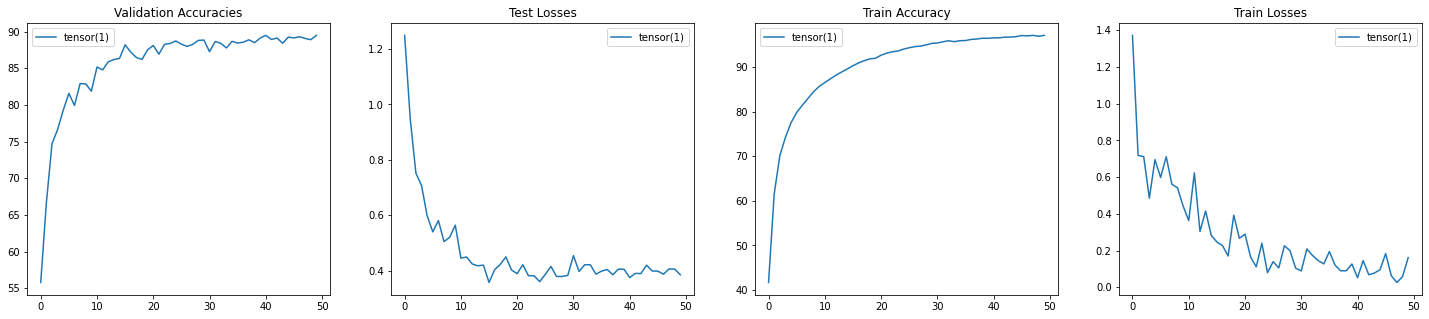

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
    
figure = plt.figure(figsize=(25,5))
#labels = ['With L1=0.001 & L2=0.0005']

plt.subplot(1,4,1)
plt.title("Validation Accuracies")
plt.plot(test_acc_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,2)
plt.title("Test Losses")
plt.plot(test_loss_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,3)
plt.title("Train Accuracy")
plt.plot(train_acc_all,label=labels[0])
plt.legend(loc="best")   

plt.subplot(1,4,4)
plt.title("Train Losses")
plt.plot(train_loss_all,label=labels[0])
plt.legend(loc="best")    

In [17]:
# Plotting misclassified images received from last epoch. Will throw error message if misclassified images <25. 
# In case of such an event adjust the subplots to suit the number of images to be plotted

import matplotlib.pyplot as plt
figure=plt.figure(figsize=(12,12))
if len(predicted_class) > 25: 
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.axis(False)
      #plt.imshow(unnormalize(wrong_predict[i].cpu()), interpolation='none')
      plt.imshow(unnormalize(wrong_predict[i].cpu()),interpolation='bilinear')
      prediction = class_names_dict.get(predicted_class[i])
      actual     = class_names_dict.get(actual_class[i])
      s="pred="+str(prediction)+" act="+str(actual)
      #s="predicted="+str(predicted_class[i])+" actual="+str(actual_class[i])
      plt.text(2,-1,s)
else:
  print('Less than 25 images:', len(predicted_class))

NameError: ignored

<Figure size 864x864 with 0 Axes>

In [0]:
! ls

data  models  README.md  S9_GradCam_Images  S9_GradCam_Images.zip


In [0]:
import zipfile
from zipfile import ZipFile 
file_name = "S9_GradCam_Images.zip"
with ZipFile(file_name, 'r') as zip: 
     zip.printdir()
     zip.extractall() 

File Name                                             Modified             Size
S9_GradCam_Images/                             2020-03-21 20:50:24            0
S9_GradCam_Images/Bird_1.jpg                   2020-03-21 17:40:44       136259
S9_GradCam_Images/Car_1.jpg                    2020-03-21 17:39:56       232076
S9_GradCam_Images/Cat_1.jpg                    2019-12-05 21:42:24        28789
S9_GradCam_Images/Deer_1.jpg                   2020-03-21 17:44:44       232142
S9_GradCam_Images/Dog_1.jpg                    2020-03-21 17:43:24       482834
S9_GradCam_Images/Frog_1.jpg                   2020-03-21 17:42:40       308961
S9_GradCam_Images/Horse_1.jpg                  2020-03-21 17:42:50       243834
S9_GradCam_Images/Plane_1.jpg                  2020-03-21 17:38:26       444681
S9_GradCam_Images/Plane_2.jpg                  2020-03-21 20:50:24       103991
S9_GradCam_Images/Ship_1.jpg                   2020-03-21 17:43:00       232440
S9_GradCam_Images/Truck_1.jpg           

In [0]:
for img in os.listdir('S9_GradCam_Images/'):  
    img_name = os.path.join('S9_GradCam_Images/',img)  # convert to array
    print(img_name)

S9_GradCam_Images/Bird_2.jpg
S9_GradCam_Images/Cat_2.jpg
S9_GradCam_Images/Car_2.jpg
S9_GradCam_Images/Dog_1.jpg
S9_GradCam_Images/Frog_1.jpg
S9_GradCam_Images/Deer_1.jpg
S9_GradCam_Images/Car_1.jpg
S9_GradCam_Images/Dog_2.jpg
S9_GradCam_Images/Cat_1.jpg
S9_GradCam_Images/Bird_1.jpg
S9_GradCam_Images/Ship_1.jpg
S9_GradCam_Images/Horse_2.jpg
S9_GradCam_Images/Truck_1.jpg
S9_GradCam_Images/Ship_2.jpg
S9_GradCam_Images/Plane_2.jpg
S9_GradCam_Images/Plane_1.jpg
S9_GradCam_Images/Horse_1.jpg


##Gradcam



In [0]:
import cv2
import urllib
import numpy as np
from google.colab.patches import cv2_imshow

def getimage(img, transform, input_size=(32,32)):
    img = cv2.imread(img, 1)
    img = img[:,:, -1::-1]
    img = np.uint8(cv2.resize(img, input_size))
    return transform(img)

In [0]:
gradcam_images = [(0, 'S9_GradCam_Images/Plane_2.jpg'),
                  (1, 'S9_GradCam_Images/Car_2.jpg'),
                  (2, 'S9_GradCam_Images/Bird_2.jpg'),
                  (3, 'S9_GradCam_Images/Cat_2.jpg'),
                  (4, 'S9_GradCam_Images/Deer_1.jpg'),
                  (5, 'S9_GradCam_Images/Dog_2.jpg'),
                  (6, 'S9_GradCam_Images/Frog_1.jpg'),
                  (7, 'S9_GradCam_Images/Horse_2.jpg'),
                  (8, 'S9_GradCam_Images/Ship_2.jpg'),
                  (9, 'S9_GradCam_Images/Truck_1.jpg')]

images = []
target_classes = []

for i in gradcam_images:
  images.append(getimage(i[1], test_transforms))
  target_classes.append(i[0])

In [0]:
target_classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


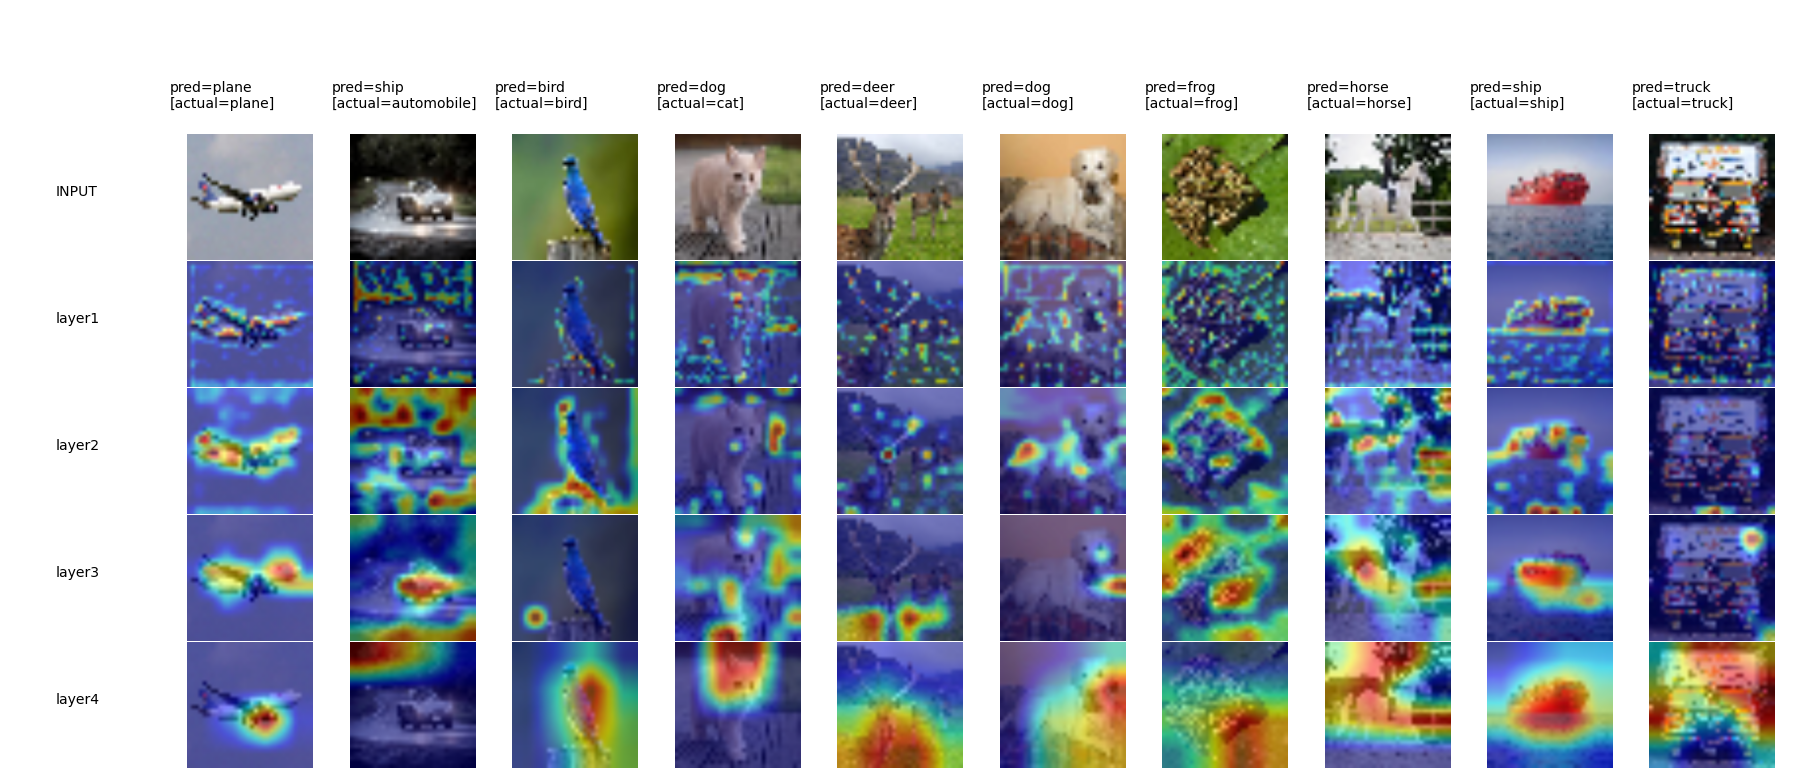

In [0]:
target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = Gradcam.GRADCAM(images, target_classes, model, target_layers)
Gradcam.PLOT(gradcam_output, images, target_classes, target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)